## Hessian of the Functional as a BenchMark of Phase transitions

We know that the signature of the 2nd order phase transition is a singularity in the II derivative of the energy respect the order parameter

####  $\chi_{ij}(h)=\frac{\partial^2 E(h)}{\partial h_i \partial h_j}$
The problem is that this quantity is hard to compute and leads to high inaccuracies in catching the phase transition. The good thing is that Deep Learning Libraries as Pytorch have a really powerfull tool for computing derivatives (Autograd) that makes the operation totally indipendent of the scale of the increment.

However, In Density Functional Theory we deal with Functional of the magnetization $z$. In our case we know that the connection between Susceptivity and the derivatives of the Functional is

#### $\chi_{ij}(h)=-(\frac{\partial^2 E(z)}{\partial z_i \partial z_k})^{-1} \frac{\partial^2 E(z)}{\partial z_k \partial z_l} (\frac{\partial^2 E(z)}{\partial z_l \partial z_j})^{-1}=-(\frac{\partial^2 E(z)}{\partial z_i \partial z_j})^{-1}$

Because 

#### $h_i=-\frac{\partial E(z)}{\partial z_i}$

In order to do that we have two stategies: The first one is to compute the inverse of the Hessian of the neural network $E[z]$, but this would lead to high inaccuracies given by the repetition of backpropagations.

A less elegant way but more safe is to map the functional $\frac{\partial E[h]}{\partial h}=n$ and then compute the Hessian of this by simple backpropagation and test it on the minimum gradient Configurations


## Study the Accuracy of The gradient and the Scalability

#### Imports

In [127]:
import numpy as np
import torch 
import matplotlib.pyplot as plt
from tqdm import trange


### Data

In [128]:
ls=[16,32,48,64,128]
h={}
hs=[2.65,2.7,2.75]
model={}

for hmax in hs:
    model[hmax]=torch.load(f'model_rep/1nn_field2den/h_{hmax}_15k_unet_periodic_[40, 40, 40, 40]_hc_5_ks_1_ps_4_nconv_0_nblock',map_location='cpu')
    model[hmax].eval()
    for l in ls:
        data=np.load(f'data/dataset_1nn/field2density_221122/valid_unet_periodic_{l}_l_{hmax:.1f}_h_200_n.npz')
        h[(l,hmax)]=torch.tensor(data['potential']).double()

#### Gradient

In [129]:
dde={}
ndata=200
for hmax in hs:
    for l in ls:
        dde_l=np.zeros((h[(l,hmax)].shape[0],l,l))
        #for i in trange(l):
        h[(l,hmax)].requires_grad_(True)
        for i in trange(l):
            dedh=model[hmax](h[(l,hmax)])[:,i]
            dedh.backward(torch.ones_like(dedh))
            with torch.no_grad():
                dd = h[(l,hmax)].grad.detach().numpy()
                dde_l[:,:,i]=dd
                h[(l,hmax)].grad.zero_()    
        dde[(l,hmax)]=dde_l
        
            
            

100%|██████████| 128/128 [00:51<00:00,  2.47it/s]


#### Plot the average over the disorder


In [130]:
av={}
eigh={}
for hmax in hs:
    for l in ls:
        # plt.imshow(np.average(dde[(l,hmax)],axis=0))
        # plt.colorbar()
        # plt.show()
        lambd,_=np.linalg.eigh(dde[(l,hmax)])
        eigh[(l,hmax)]=np.average(lambd,axis=0)
        av[(l,hmax)]=np.average(dde[(l,hmax)])
        


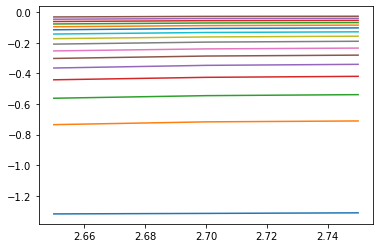

In [118]:
l=16

plt.plot(hs,[eigh[(l,h)] for h in hs])
plt.show()

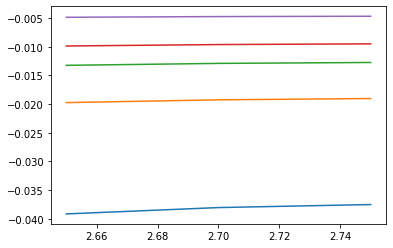

In [131]:
for l in ls:
    plt.plot(hs,[av[(l,h)] for h in hs])
plt.show()

#### Study the eigenvalue of the Hessian

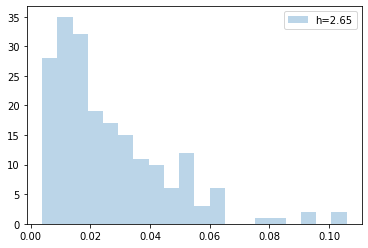

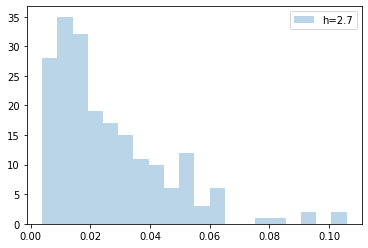

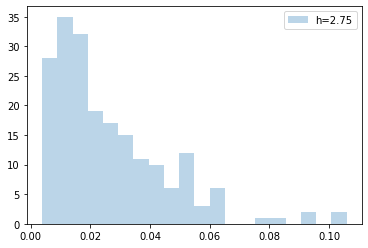

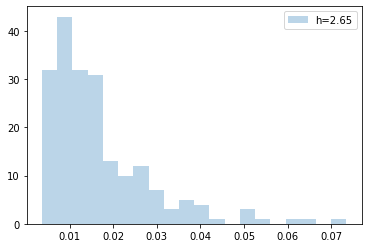

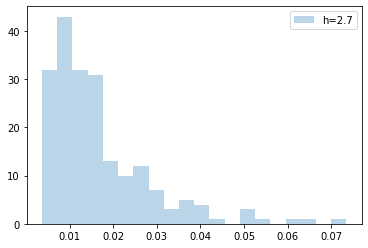

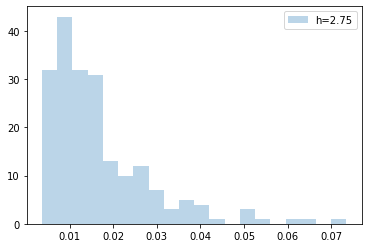

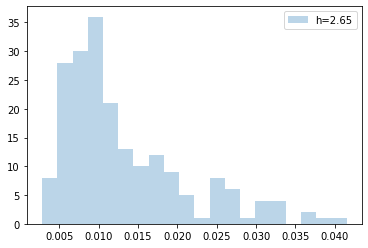

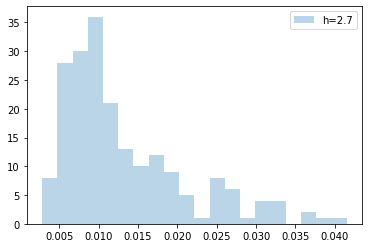

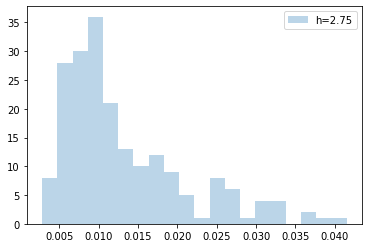

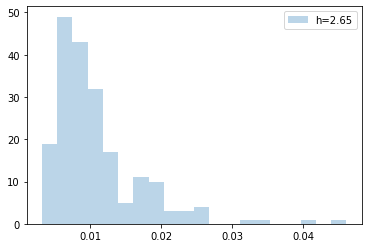

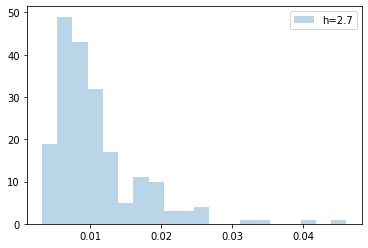

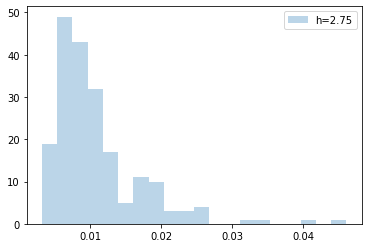

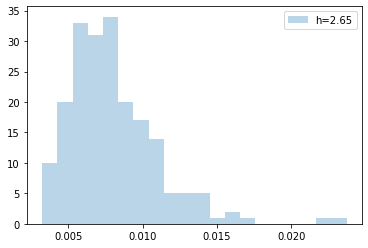

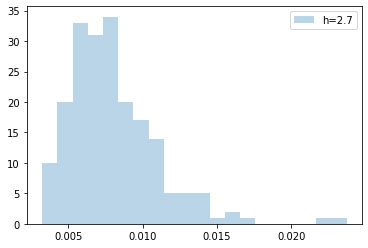

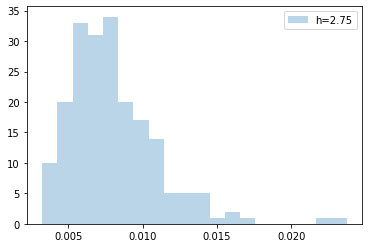

In [135]:
eig={}
for l in ls:
    for h in hs:
        lambd,_=np.linalg.eigh(dde[(l,hmax)])
        eig[(l,hmax)]=np.min(np.abs(lambd),axis=-1)

        plt.hist(eig[(l,hmax)],bins=20,label=f'h={h}',alpha=0.3)
        plt.legend()
        plt.show()